## Create fake datasets for testing

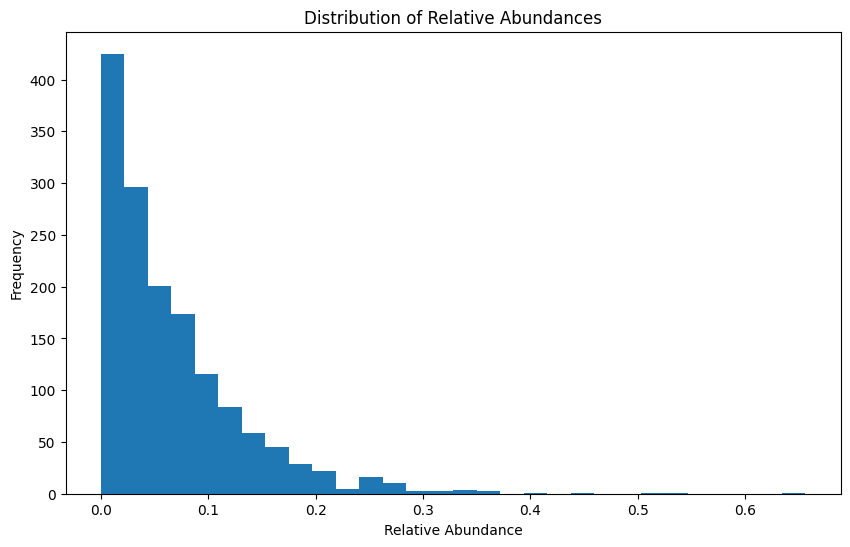

In [2]:
import matplotlib.pyplot as plt
from src.fake_data import generate_fake_data


ec_data, abundance_data = generate_fake_data(
    n_genomes=1500,
    n_ec_numbers=1000,
    min_ec=500, max_ec=700,
    abundance_scale=20
    )

# Save the data to CSV files
ec_data.to_csv('data/fake_ec_numbers.tsv', sep='\t')
abundance_data.to_csv('data/fake_abundance.tsv', sep='\t')

# Plot abundance distribution
plt.figure(figsize=(10, 6))
plt.hist(abundance_data['relative_abundance'], bins=30)
plt.title('Distribution of Relative Abundances')
plt.xlabel('Relative Abundance')
plt.ylabel('Frequency')
plt.show()

# Example using clustering to select subset

In [3]:
import pandas as pd
from src.cluster_selector import select_representative_genomes_clustering


# Load your data
ec_data = pd.read_csv("data/fake_ec_numbers.tsv", index_col="id_genome", sep="\t")
abundance_data = pd.read_csv("data/fake_abundance.tsv", index_col="id_genome", sep="\t")

# Run the selection algorithm
selected_genomes = select_representative_genomes_clustering(
    ec_data, abundance_data, n_clusters=5
)

print("Selected representative genomes:")
print(selected_genomes)

Number of genomes: 1500
Number of EC numbers: 1000
Total EC numbers covered: 978
Selected representative genomes:
['genome_1075', 'genome_675', 'genome_906', 'genome_606', 'genome_1079']


## Example using matrix decomposition


Algorithm obtained from: https://ipsen.math.ncsu.edu/ps/SIURO_01043.pdf

These are specific for binary matrices (low rank approximation of binary matrices): https://drops.dagstuhl.de/storage/00lipics/lipics-vol117-mfcs2018/LIPIcs.MFCS.2018.41/LIPIcs.MFCS.2018.41.pdf

### Deterministic subset selection

In [4]:
import pandas as pd
from src.matrix_selector import deterministic_subset_selection


ec_data = pd.read_csv("data/fake_ec_numbers.tsv", index_col="id_genome", sep="\t")
A = ec_data.values[:500,:].transpose()
k = 10

# Run the algorithm
P, (Q, R) = deterministic_subset_selection(A, k)

# The selected columns are the first k columns of A[:, P]
selected_columns = A[:, P][:, :k]

print(f"Selected {k} columns from a {A.shape} matrix.")
print(f"Shape of selected columns: {selected_columns.shape}")


Selected 10 columns from a (1000, 500) matrix.
Shape of selected columns: (1000, 10)


### Weighted deterministic subset selection

In [14]:
import pandas as pd
import numpy as np
from src.matrix_selector import weighted_deterministic_subset_selection


ec_data = pd.read_csv("data/fake_ec_numbers.tsv", index_col="id_genome", sep="\t")
abundance_data = pd.read_csv("data/fake_abundance.tsv", index_col="id_genome", sep="\t")

A = ec_data.values[:500,:].transpose()
weights = abundance_data.values[:500].flatten()
k = 10

# Run the algorithm
P, (Q, R) = weighted_deterministic_subset_selection(A, k, weights, f=1.01, alpha=0.7)

print(f"Selected {k} columns from a {A.shape} matrix.")

# Verify the results
A_1 = A[:, P[:k]]
A_2 = A[:, P[k:]]
residual = np.linalg.norm(A_2 - A_1 @ np.linalg.lstsq(A_1, A_2, rcond=None)[0], ord=2)
print(f"Residual: {residual}")
print(f"Smallest singular value of selected columns: {np.linalg.svd(A_1, compute_uv=False)[-1]}")
print(f"Average weight of selected columns: {np.mean(weights[P[:k]])}")
print(f"Average weight of all columns: {np.mean(weights)}")

Selected 10 columns from a (1000, 500) matrix.
Residual: 103.80928319639904
Smallest singular value of selected columns: 14.185197286003588
Average weight of selected columns: 0.32659481789165984
Average weight of all columns: 0.06705368751530776


### Two-stage deterministic subset selection

In [15]:
import pandas as pd
from src.matrix_selector import two_stage_deterministic_subset_selection


ec_data = pd.read_csv("data/fake_ec_numbers.tsv", index_col="id_genome", sep="\t")

A = ec_data.values[:500,:].transpose()
k = 10

# Run the algorithm
Pi, selected_columns = two_stage_deterministic_subset_selection(A, k)

print(f"Selected {k} columns from a {A.shape} matrix.")
print(f"Shape of selected columns: {selected_columns.shape}")

# Verify the results
A_1 = A[:, Pi[:k]]
A_2 = A[:, Pi[k:]]
residual = np.linalg.norm(
    A_2 - A_1 @ np.linalg.lstsq(A_1, A_2, rcond=None)[0], ord=2
)
print(f"Residual: {residual}")
print(
    f"Smallest singular value of selected columns: {np.linalg.svd(A_1, compute_uv=False)[-1]}"
)


Selected 10 columns from a (1000, 500) matrix.
Shape of selected columns: (1000, 10)
Residual: 100.60678550125486
Smallest singular value of selected columns: 14.901823025069634


### Weighted two-stage deterministic subset selection

In [16]:
import pandas as pd
from src.matrix_selector import weighted_two_stage_subset_selection

ec_data = pd.read_csv("data/fake_ec_numbers.tsv", index_col="id_genome", sep="\t")
abundance_data = pd.read_csv("data/fake_abundance.tsv", index_col="id_genome", sep="\t")

A = ec_data.values[:500,:].transpose()
weights = abundance_data.values[:500].flatten()
k = 10

# Run the algorithm
Pi, selected_columns = weighted_two_stage_subset_selection(A, k, weights, alpha=0.7)

print(f"Selected {k} columns from a {A.shape} matrix.")
print(f"Shape of selected columns: {selected_columns.shape}")

# Verify the results
A_1 = A[:, Pi[:k]]
A_2 = A[:, Pi[k:]]
residual = np.linalg.norm(
    A_2 - A_1 @ np.linalg.lstsq(A_1, A_2, rcond=None)[0], ord=2
)
print(f"Residual: {residual}")
print(
    f"Smallest singular value of selected columns: {np.linalg.svd(A_1, compute_uv=False)[-1]}"
)
print(f"Average weight of selected columns: {np.mean(weights[Pi[:k]])}")
print(f"Average weight of all columns: {np.mean(weights)}")

Selected 10 columns from a (1000, 500) matrix.
Shape of selected columns: (1000, 10)
Residual: 99.97242829396623
Smallest singular value of selected columns: 14.881154407063418
Average weight of selected columns: 0.0873632877846048
Average weight of all columns: 0.06705368751530776


In [18]:
import pandas as pd


ec_data = pd.read_csv("/home/robaina/Documents/NewAtlantis/genome_selector/data/feature_prevalence.genomes.tsv", index_col="id_genome", sep="\t")
ec_data

,1.-.-.-,1.1.1.-,1.1.1.100,1.1.1.127,1.1.1.17,1.1.1.193,1.1.1.205,1.1.1.23,1.1.1.25,1.1.1.267,...,7.2.2.1,7.2.2.5,7.2.3.1,7.3.2.1,7.3.2.2,7.4.2.1,7.4.2.8,7.5.2.-,7.5.2.5,7.6.2.9
id_genome,,,,,,,,,,,,,,,,,,,,,
OceanDNA-b16626,1,0,1,1,0,0,0,1,0,1,...,2,0,0,0,0,1,2,0,1,1
OceanDNA-b16627,1,0,1,1,0,0,0,1,1,1,...,1,0,0,0,0,1,1,0,1,1
OceanDNA-b16628,1,0,1,1,0,0,0,0,1,1,...,1,0,0,0,0,1,0,0,0,1
OceanDNA-b16676,0,0,1,0,0,0,0,1,1,1,...,1,1,0,1,0,1,0,0,0,0
OceanDNA-b16692,2,0,1,0,0,1,0,1,1,1,...,1,0,0,1,0,1,1,0,1,0
OceanDNA-b2171,0,1,1,0,0,0,0,0,0,0,...,1,0,0,0,1,1,1,1,0,0
OceanDNA-b2179,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
OceanDNA-b25795,0,1,0,0,0,1,1,0,1,1,...,0,0,1,0,0,0,1,0,0,0
OceanDNA-b7887,0,1,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
